# Modeling
Solve for the kinematic model used to simulate the trailer system. Below an overview of the system is seen, with all relevant variable and parameter definitions. 

The vectors $\vec{r}_{ihj}$ running from each coordinate system origin $i$ to the next hinge points $j$ have the length 

$|| \vec{r}_{ihj}  || = {r}_{ihj}$

The angles $q_i$ describe the angle between coordinate axis $i$ and $i+1$ about axis $z_i$, so for instance $q_0$ describes the angle between $x_0$ and $x_1$ about $z_0$. 

Equations of motions are derived by equations the velocity at the hinge points for each body. The velocity for the hinge on the truck for instance is $\dot{\vec{h}}_1$.


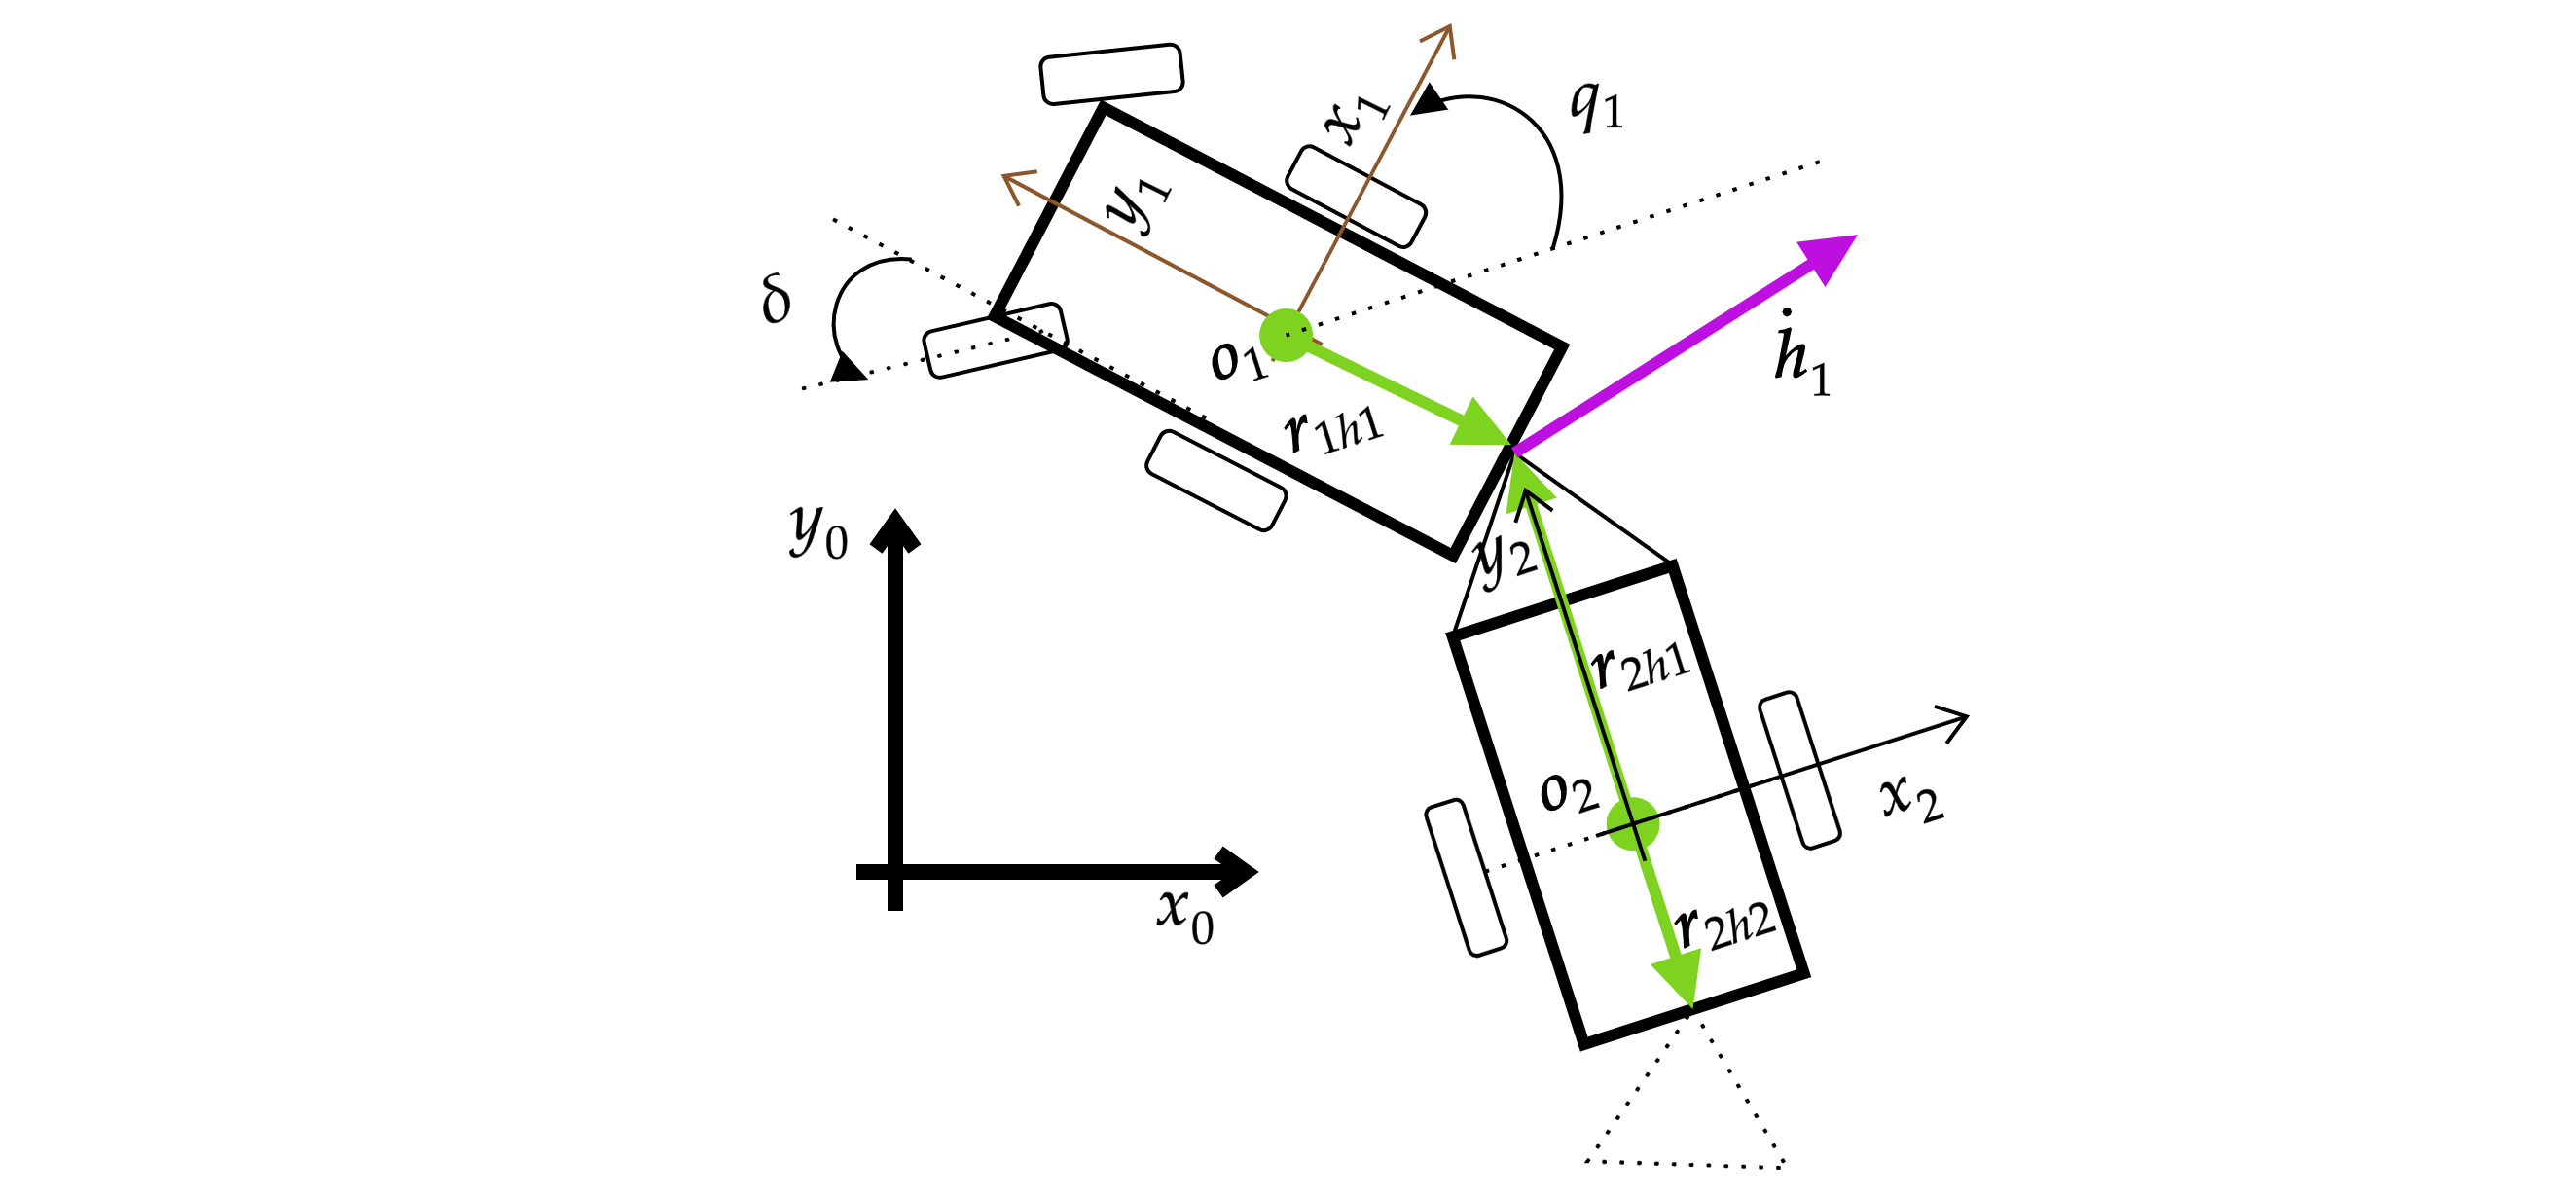



In [ ]:
from sympy.solvers import solve
from sympy import *
from sympy import Function, Symbol
#from __future__ import division
from sympy import var, latex
from sympy import rot_axis3
from sympy.matrices import *
from sympy.vector import CoordSys3D

In [ ]:
var('t')
#Angles and their derivatives. 
var('q0, q1, q2')
#q0 = Function('q0')(t)
#q1 = Function('q1')(t)
#q2 = Function('q2')(t)

var('q0_d, q1_d, q2_d')

#Scalar components of velocity for each of the bodies as expressed in the world frame. 
var('v2y, v3y')

#Control signals, truck velocity v1 and steering angle delta. 
var('v1, delta')

#Scalar length origin i --> hinge j  rihj
var('r1h1, r2h1, r2h2, r3h2')


Rotation matrices. Expreses a vector expressed in frame index $k$ in the frame index $l$, as **l_to_k**

In [ ]:
#From frame i to previous frame
R_1_to_0 = rot_axis3(q0)
R_2_to_1 = rot_axis3(q1)
R_3_to_2 = rot_axis3(q2)

#From frame i to next frame 
R_0_to_1 = rot_axis3(-q0)
R_1_to_2 = rot_axis3(-q1)
R_2_to_3 = rot_axis3(-q2)

#Combined rotations.
R_2_to_0 = ImmutableDenseMatrix(R_1_to_0*R_2_to_1).simplify()
R_3_to_0 = ImmutableDenseMatrix(R_1_to_0*R_2_to_1*R_3_to_2).simplify()

In [ ]:
#Print out a matrix and see if it makes sense. 
#R_3_to_0

#A proper rotation matrix has its tranpose as inverse. 
R_1_to_0 - R_0_to_1.transpose()

In [ ]:
R_0_to_1

## Equations of motion
Derive the equations of motion by analysing the kinematics as expressed in each body frame. Note that the origin velocity only has one $y_i$ component in each coordinate system $i$ in each body frame, as the system cannot move sideways. This is called a *non-holonomic constraint*. Then, we use the general formula for a geometric derivative of a vector using a cross product. Remember that by expressing all involved vectorial quantities of the cross product in some frame, the resulting vector is also expressed in that frame. However, it still describes the movement with respect to the world frame. 


In [ ]:
v1_in_1 = Matrix([0, v1, 0])

v1_in_0 = R_1_to_0*v1_in_1

#Rotational velocity of each body wrt. to global frame 0, found by inspection.  
w1 = Matrix([0, 0, q0_d])
w2 = Matrix([0, 0, q0_d+q1_d])
w3 = Matrix([0, 0, q0_d+q1_d+q2_d])

#Express hinge 1 velocity in frame 1 
v_h1_in_1 = v1_vec + w1.cross( Matrix([0, -r1h1, 0])  )

#And similarly in frame 2 
v_h1_in_2 = Matrix([0, v2y, 0]) + w2.cross( Matrix([0, r2h1, 0])  )




In [ ]:
v_h1_in_1

In [ ]:
v1_in_0

In [ ]:
v_h1_in_2

Try to solve the equations of motion by equating the expressions for the hinge velocity. Todo this we have to perform a change of frame so both vector are expressed in the same coordinate system. We do this by using a rotation matrix.

In [ ]:
#The solution for when this is zero. 
eqToSolve = v_h1_in_2 - R_1_to_2*v_h1_in_1

In [ ]:
eqToSolve

In [ ]:
sol_trailer1 = solve(eqToSolve, [q1_d, v2y])
q1d_sol = sol_trailer1[q1_d]
v2y_sol = sol_trailer1[v2y]

In [ ]:
#See the whole solution
q1d_sol

In [ ]:
#Sanity check: If q1 = 0 (trailer is aligned with truck)and the trailers is hitched directly to the origin, the rate of change 
#of the angle between the truck and the trailer should be 
sol_trailer1[q1_d].subs(q1,0).subs(r1h1,0).simplify()

In [ ]:
#If the trailer is hithced directly to the origin of the truck, the angular velocity between them is 
#truck rotation + a contribution of the truck pulling the hinge sideways , seen from the trailers perspective
sol_trailer1[q1_d].subs(r1h1,0).simplify()

In [ ]:
sol_trailer1[v2y].simplify()

Attach another trailer called trailer 2 onto traielr 1 and solve simiarily

In [ ]:
#Express hinge 2 velocity in frame 2 
v2y_sol = sol_trailer1[v2y]
v_h2_in_2 = Matrix([0, v2y_sol, 0])  + w2.cross( Matrix([0, -r2h2, 0])  )
#v_h2_in_2 = Matrix([0, v2y, 0])  + w2.cross( Matrix([0, -r2h2, 0])  )

#And similarly in frame 3 
v_h2_in_3 = Matrix([0, v3y, 0]) + w3.cross( Matrix([0, r3h2, 0])  )

sol_trailer2  = solve( v_h2_in_3 - R_2_to_3*v_h2_in_2     , [q2_d, v3y])

#Subsitute in the solution for q1_d
#q2_d_sol = sol_trailer2[q2_d].subs(q1_d, q1d_sol).simplify()
#Or use this.
q2_d_sol = sol_trailer2[q2_d].simplify()
v3y_sol  = sol_trailer2[v3y].simplify() 



In [ ]:
q2_d_sol

In [ ]:
q1d_sol

### Check for errors
We know the trailer origins should not move sideways, implying the dot product between the velocity $v_{yi}$ and the solutions and the $x_i$ axis for the trailer should be zero. Remeber that the rotation matrices contain the unit vectors for each coordinate system, as columns. 

In [ ]:
v3_in_0 = R_3_to_0*Matrix([0, v3y_sol, 0])
ex3_in_0 =R_3_to_0[:,0] 
ey3_in_0 =R_3_to_0[:,1] 

v2_in_0 = R_2_to_0*Matrix([0, v2y_sol, 0])
ex2_in_0 =R_2_to_0[:,0] 


In [ ]:
v3_in_0.dot(ex3_in_0)

In [ ]:
#Dot product between unit vector for y axis in the velocity in that frame should be non-zero
v3_in_0.dot(ey3_in_0).simplify()

In [ ]:
v2_in_0.dot(ex2_in_0)

# Exports 


Latex export for reports etc. 

In [ ]:
print(latex(q1d_sol))

In [ ]:
#Collect terms a bit. 
q2_d_coll = collect(q2_d_sol,[q0_d,q1_d, q2_d])

In [ ]:
q2_d_sol

In [ ]:
q2_d_coll

In [ ]:
q2_d_coll_str = latex(q2_d_coll)

In [ ]:
print(q2_d_coll_str)

In [ ]:
#Replace things we didn't like 
q2_d_coll_str = q2_d_coll_str.replace('q_{0 d}', '\dot{q}_0' )
q2_d_coll_str = q2_d_coll_str.replace('q_{1 d}', '\dot{q}_1' )
q2_d_coll_str = q2_d_coll_str.replace('r3h2', 'r_{3h2}' )
q2_d_coll_str = q2_d_coll_str.replace('r2h2', 'r_{2h2}' )
q2_d_coll_str = q2_d_coll_str.replace('r2h1', 'r_{2h1}' )
q2_d_coll_str = q2_d_coll_str.replace('r1h1', 'r_{1h1}' )

q2_d_coll_str = q2_d_coll_str.replace("\\sin{\\left(q_{1} \\right)}", "S_{q1}" )
q2_d_coll_str = q2_d_coll_str.replace('\\sin{\\left(q_{2} \\right)}', 'S_{q2}' )
q2_d_coll_str = q2_d_coll_str.replace('\\cos{\\left(q_{1} \\right)}', 'C_{q1}' )
q2_d_coll_str = q2_d_coll_str.replace('\\cos{\\left(q_{2} \\right)}', 'C_{q2}' )

#metext = "\sin{\left(q_{1} \right)} lalalal"
#print(metext.replace("\sin{\left(q_{1} \right)}", "sin"))

print(q2_d_coll_str)

Export these equations to numpy so we can simulate them.

In [ ]:
from sympy import sin, cos, symbols, lambdify
import numpy as np

In [ ]:
f = lambdify(q1_d, q1d_sol, 'numpy')

In [ ]:
f(2)

In [ ]:
from sympy import sin, cos, symbols, lambdify
import numpy as np
x = symbols('x')
c = symbols('c')
expr = sin(x) + cos(x)

f = lambdify(x, expr, 'numpy')
a = np.array([1, 2])
f(a)
